<a href="https://colab.research.google.com/github/hiyer7/Jamboree-Education---Linear-Regression/blob/main/Jamboree_Education_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Objective

The primary goal of this case study was to build a regression model to predict the Chance of Admit based on applicants’ academic and profile-related features, such as GRE scores, TOEFL scores, CGPA, SOP, LOR, University Rating, and Research experience.

#Library Imports

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

#Data Read

In [30]:
url = 'https://raw.githubusercontent.com/hiyer7/Jamboree-Education---Linear-Regression/refs/heads/main/Jamboree_Admission.csv'
df = pd.read_csv(url)
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


#1. EDA

##Columns

In [3]:
df.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')

There are trailing spaces in the column names, we will be fixing it by striping the column names

In [4]:
df.columns = df.columns.str.strip()
df.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR', 'CGPA', 'Research', 'Chance of Admit'],
      dtype='object')

##Checking for Data Types

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         500 non-null    int64  
 1   GRE Score          500 non-null    int64  
 2   TOEFL Score        500 non-null    int64  
 3   University Rating  500 non-null    int64  
 4   SOP                500 non-null    float64
 5   LOR                500 non-null    float64
 6   CGPA               500 non-null    float64
 7   Research           500 non-null    int64  
 8   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


##Checking for empty rows

In [6]:
for col in df.columns:
  print(f"{col}: {df[col].isna().sum()}")

Serial No.: 0
GRE Score: 0
TOEFL Score: 0
University Rating: 0
SOP: 0
LOR: 0
CGPA: 0
Research: 0
Chance of Admit: 0


**Observation:**  There are no empty columns

##Dropping the irrelevant columns from the dataframe

In [7]:
for col in df.columns:
  print(f"{col}: {df[col].nunique()}")

Serial No.: 500
GRE Score: 49
TOEFL Score: 29
University Rating: 5
SOP: 9
LOR: 9
CGPA: 184
Research: 2
Chance of Admit: 61


The Columns Serial number has unique value for every data point.

1. This is irrelevant for the prediction
2. If not dropped, the liner regression model might try to bring unique patterns and might mislead the prediction.
3. Removing such unique identifiers, the model will be trained only on relevant data. This will improve the interpretability and preformance of the model.

In [9]:
df.drop(columns="Serial No.", inplace=True)

#2. Variate Analysis using Visualization

##Univariate Analysis

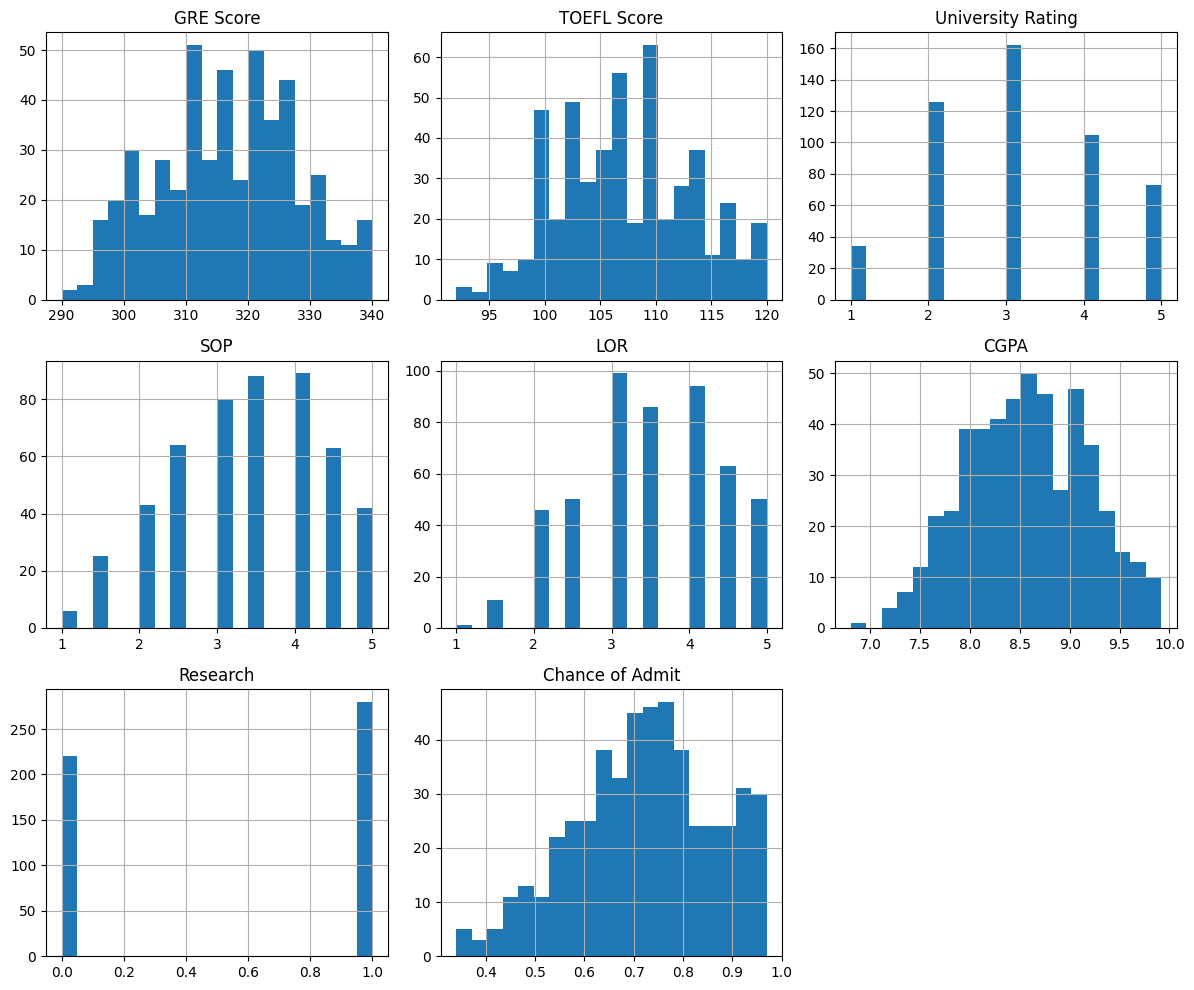

In [10]:
df.hist(figsize=(12,10), bins=20)
plt.tight_layout()
plt.show()

##Categorical Analysis

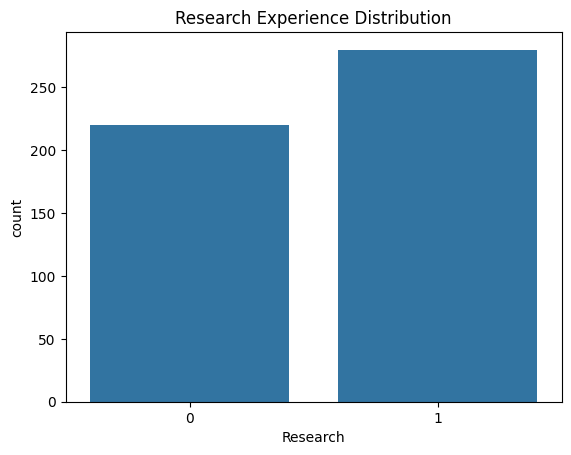

In [11]:
sns.countplot(x='Research', data = df)
plt.title('Research Experience Distribution')
plt.show()

Looks like an unbalanced data, but this is not our focus, so we will ignore it

##Bivariate Analysis

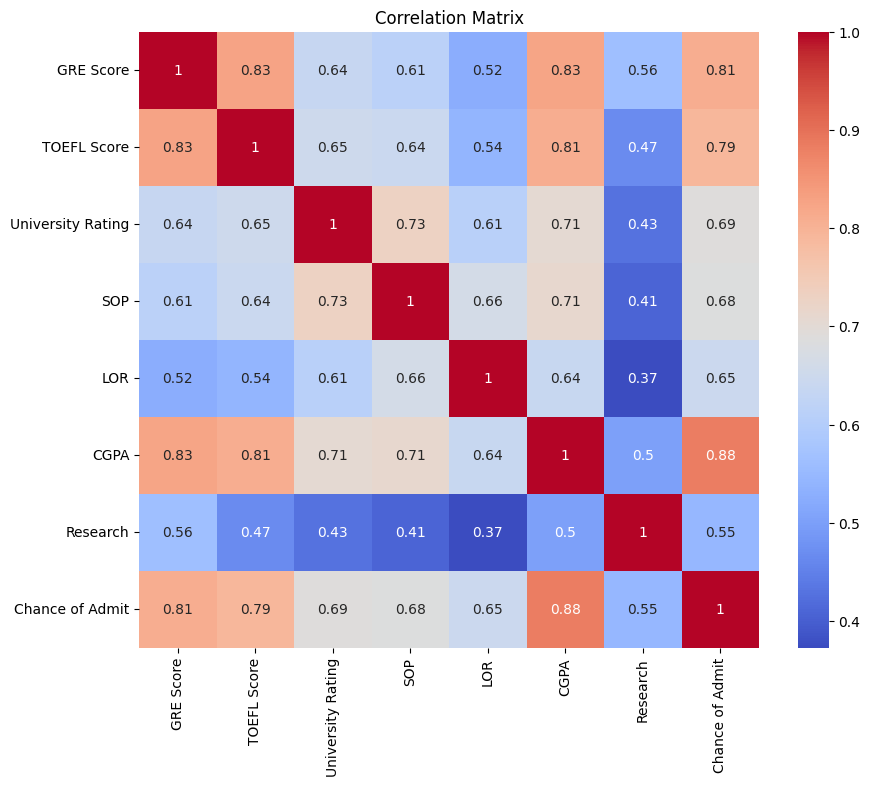

In [12]:
plt.figure(figsize=(10,8))
sns.heatmap(data=df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Note**: We will revisit and explore this later in the case study while checking collinearity between the features

##Pairplot

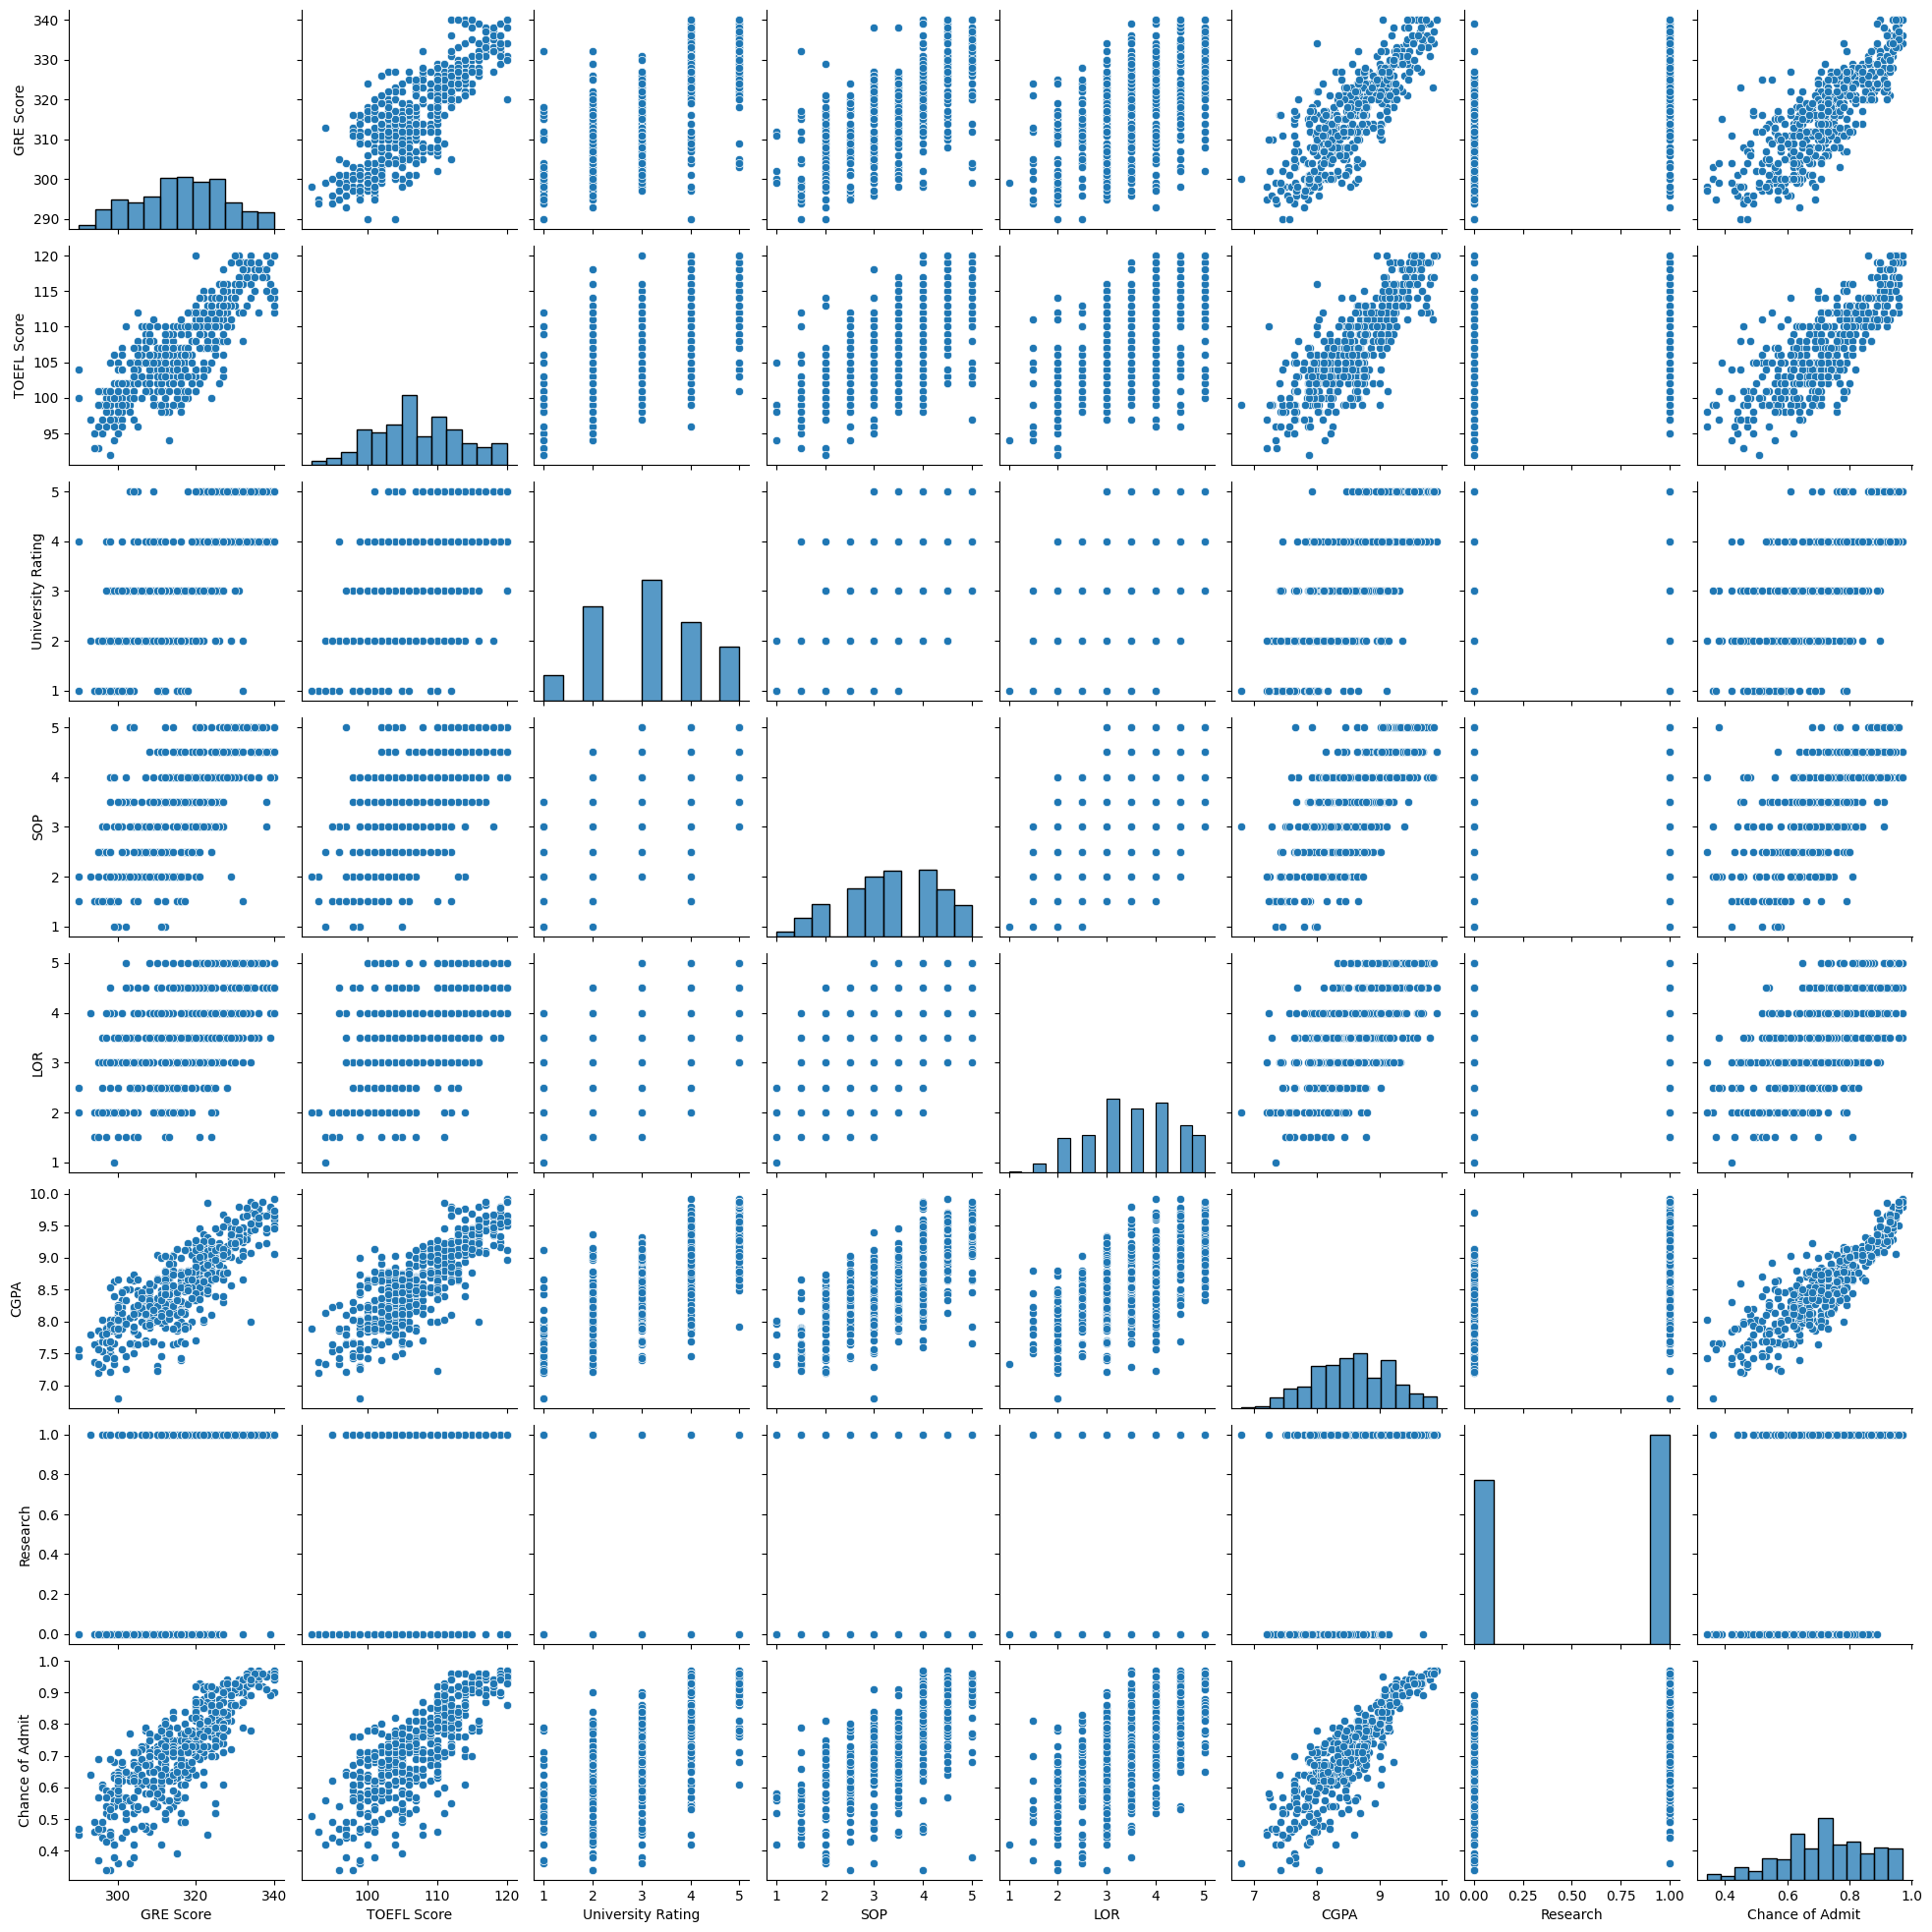

In [13]:
sns.pairplot(df)
plt.show()

We will consider the collinearity between these features when we work on the assumptions of linear model

#3. Data Preprocessing

##Outliear detection

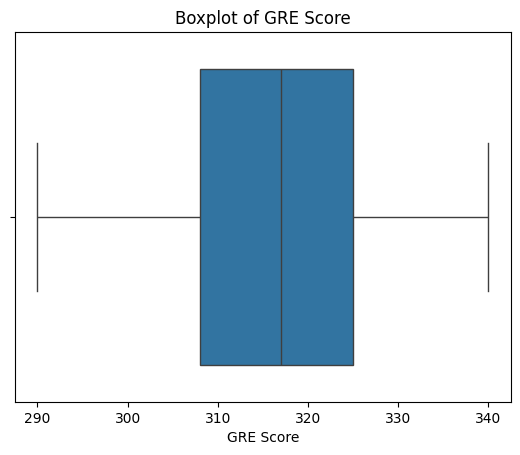

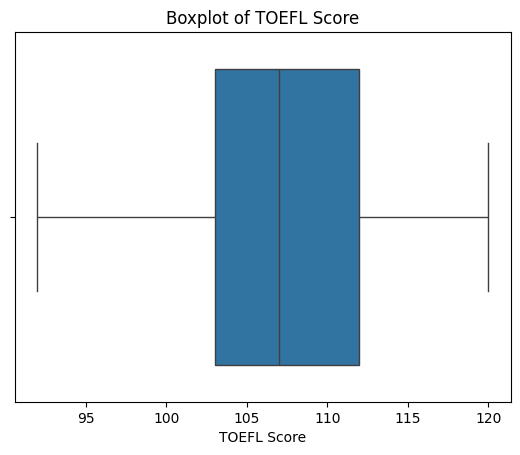

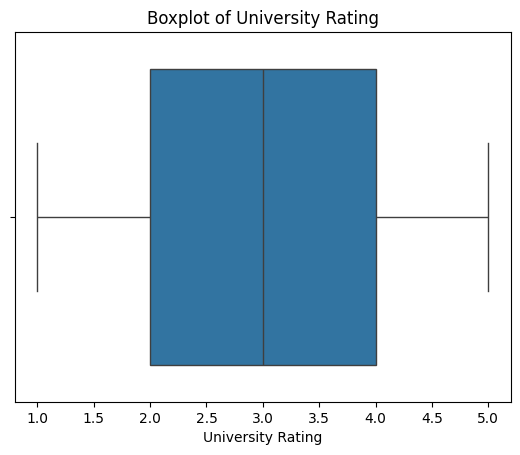

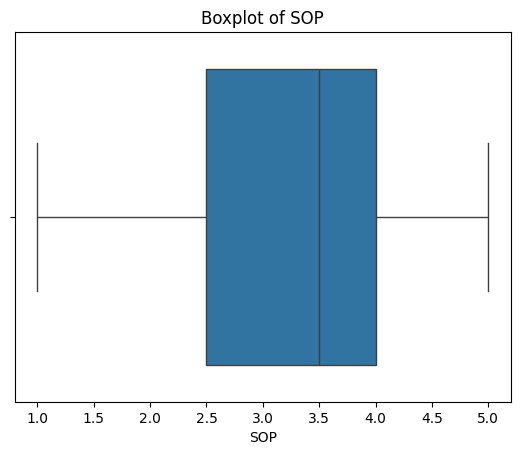

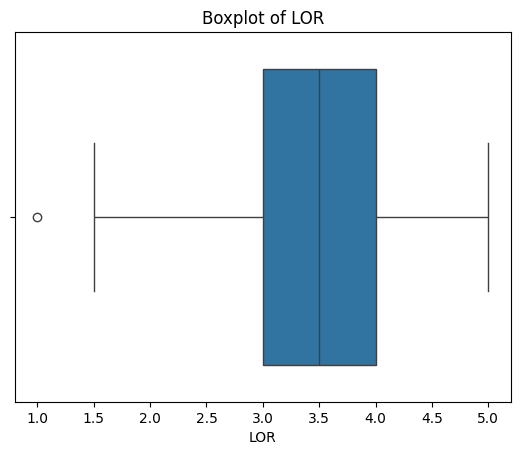

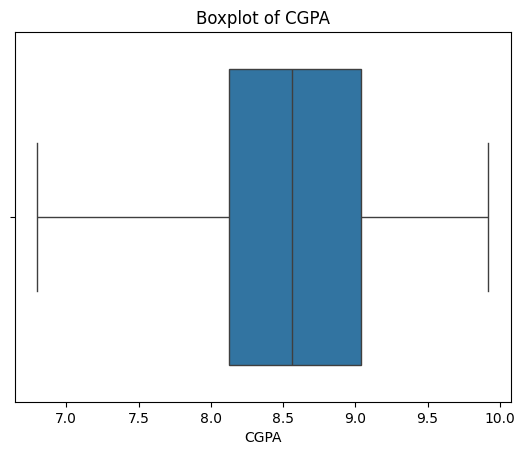

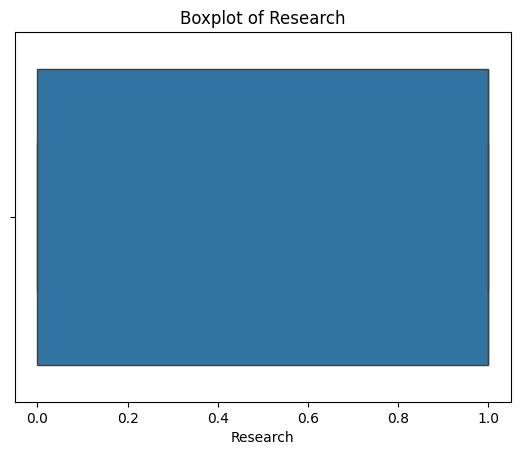

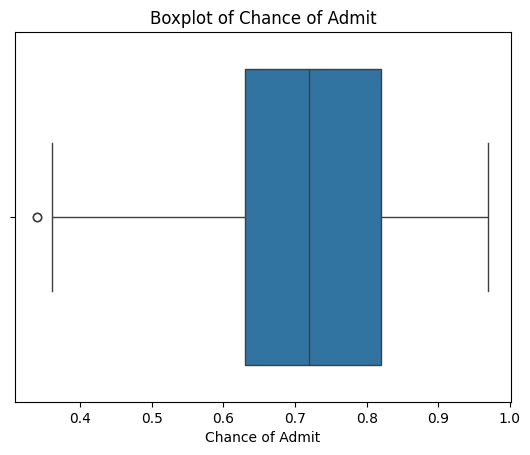

In [17]:
for col in df.columns:
  sns.boxplot(x=df[col])
  plt.title(f'Boxplot of {col}')
  plt.show()

##Using IQR method

In [18]:
outlier_counts = {}
for col in df.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]

    outlier_counts[col] = outliers.shape[0]

print(outlier_counts)


{'GRE Score': 0, 'TOEFL Score': 0, 'University Rating': 0, 'SOP': 0, 'LOR': 1, 'CGPA': 0, 'Research': 0, 'Chance of Admit': 2}


**Inference**

There is only a small number of outliers

**Conclusion:**

These wont affect the model accuracy, so we will not remove them

##Spliting Dataset into Features and Target

'Chance of Admit' is our target column.
We will be dropping this column and setting it as our y


In [19]:
y = df['Chance of Admit']

x = df.drop(columns='Chance of Admit')

**Note:**

We split the data into train, validation, and test sets before:

Scaling: To avoid data leakage (letting test data influence scale/mean of train data).

Model building: To evaluate generalization on unseen data.

#4. Model Building

In [20]:
stscaler = StandardScaler()
x_scaled = pd.DataFrame(stscaler.fit_transform(x), columns=x.columns)
x_const = sm.add_constant(x_scaled)
model = sm.OLS(y, x_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Chance of Admit   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     324.4
Date:                Sat, 14 Jun 2025   Prob (F-statistic):          8.21e-180
Time:                        01:50:29   Log-Likelihood:                 701.38
No. Observations:                 500   AIC:                            -1387.
Df Residuals:                     492   BIC:                            -1353.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7217      0.00

Summary Interpretation:

1. Overall Model Fit
R-squared = 0.822: This means 82.2% of the variance in the Chance of Admit is explained by the model's predictors — a strong fit.

2. Adjusted R-squared = 0.819: After adjusting for the number of predictors, the model still explains ~81.9% variance, suggesting the variables are informative and not overfitting.

3. F-statistic = 324.4 with p-value ≈ 0.000: The model as a whole is statistically significant. At least one predictor significantly impacts the target.

4. The model is strong overall, with CGPA, GRE, TOEFL, LOR, and Research being statistically significant predictors.

5. University Rating and SOP are not statistically significant, i.e., their contribution isn't strongly supported by the data. They may be considered for removal or further investigation.

6. Some regression assumptions (normality & independence of residuals) are violated — consider residual plots or transformation techniques.

We will explore Ridge or Lasso for regularization and check multicollinearity (VIF), in the next blocks.

#5. Assumptions of Linear Regression

These are the five assumptions of **Linear Regression**:

1. Linearity Between Predictors and Target
There should be a linear relationship between each independent feature and the target variable.

How to check:

a. Scatter plots of each feature against the target variable.

b. Correlation coefficient (Pearson's r) to quantify the strength and direction of the relationship.

2. No Multicollinearity Between Features
The independent variables should not be highly correlated with each other.

How to check:

a. Correlation matrix (heatmap) to visually inspect pairwise relationships.
(from above)
b. Variance Inflation Factor (VIF):

VIF > 5 (or sometimes > 10) suggests significant multicollinearity.

Variables with high VIF should be considered for removal, transformation, or regularization.

3. Normality of Residuals
The residuals (errors) should be normally distributed, especially for inference tasks like confidence intervals or hypothesis testing.

How to check:

a. Histogram or Q-Q plot of residuals.

Shapiro-Wilk test for statistical normality.

4. Homoscedasticity (Constant Variance of Errors)
The variance of residuals should remain constant across all levels of predicted values.


Residuals vs Fitted plot: Look for a random scatter (no funnel shape).


5. No Autocorrelation in Residuals
Residuals should be independent of each other, especially important in time series data.

How to check:

Durbin-Watson statistic:

Values ~2 suggest no autocorrelation.

Values <2 indicate positive autocorrelation.

Values >2 indicate negative autocorrelation.

ACF (Autocorrelation Function) plot of residuals.


###1. Collinearity between features and the target

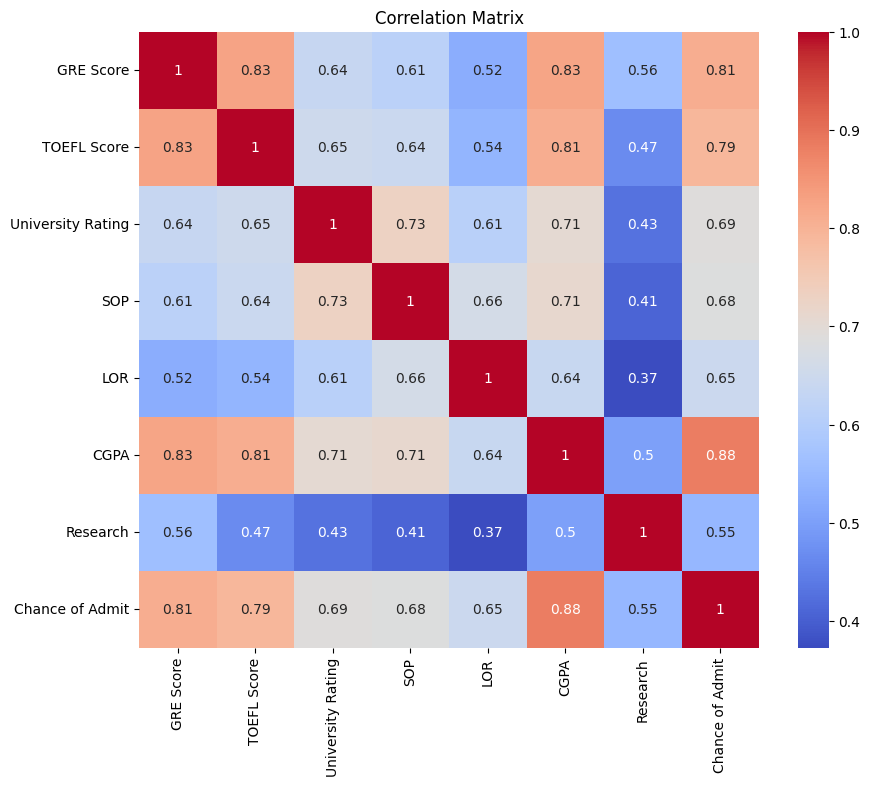

In [28]:
plt.figure(figsize=(10,8))
sns.heatmap(data=df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Inference**

All the features are correlated to the target

**Conclusion:**

We do not have to drop ant features based on this

###2. Using VIF to determine collinearity between the features

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = x_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(x_scaled.values, i)
                   for i in range(x_scaled.shape[1])]
print(vif_data)

             feature       VIF
0          GRE Score  4.464249
1        TOEFL Score  3.904213
2  University Rating  2.621036
3                SOP  2.835210
4                LOR  2.033555
5               CGPA  4.777992
6           Research  1.494008


**Inference**

All the VIF scores are less than 5 hence we can deduce that there is no strong collinearity between the features

**Conclusion:**
We do not have to drop any features because of this



###3. Normality of residuals

In [23]:
residuals = model.resid
print("Mean of residuals:", residuals.mean())

Mean of residuals: -3.304023721284466e-16


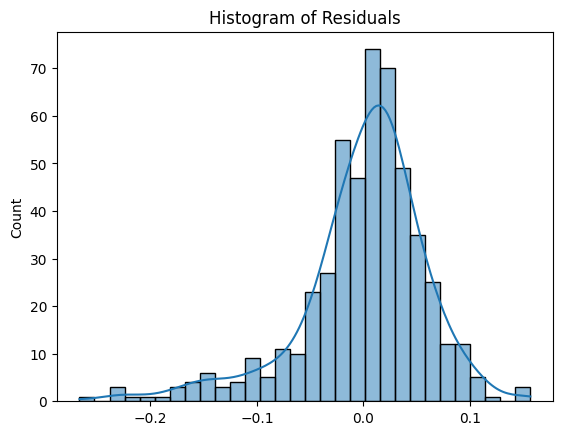

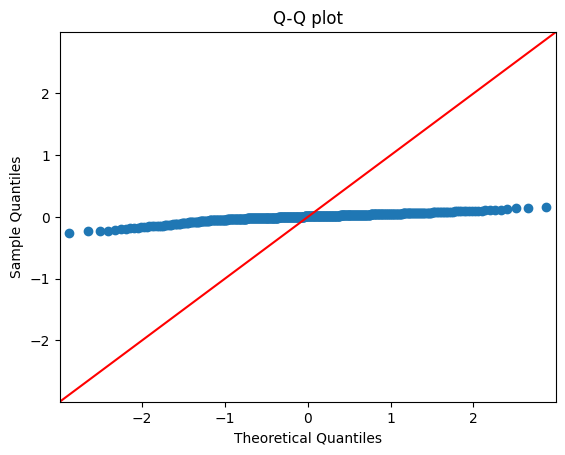

In [25]:
import scipy.stats as stats

sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()

sm.qqplot(residuals, line='45')
plt.title("Q-Q plot")
plt.show()

**Inference:**

1. Histogram of Residuals
The residuals appear roughly bell-shaped and centered around zero, which is a good sign.
However, there is slight skewness visible — more residuals on the left side.
The presence of kinks or multi-modal dips may suggest some minor non-normality, but it's not severe.

2. Q-Q Plot (Quantile-Quantile Plot)
The points deviate from the red 45° line, especially in the tails.
The center region follows the line reasonably well.
The flattening pattern indicates that the residuals are less variable than a normal distribution → possibly platykurtic (thin-tailed).



**Conclusion:**

1. Almost normal, mild skew. Could be acceptable depending on the use case.

2. There's evidence of non-normality, especially in the tails.
This may not invalidate the model, but it can affect p-values and confidence intervals.

###4. Homoschedasticity

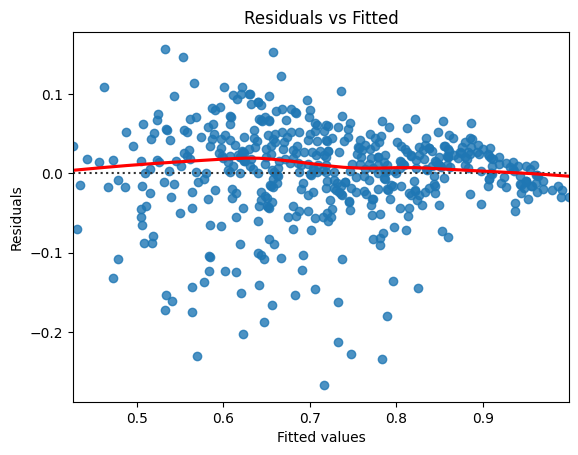

In [24]:
fitted = model.fittedvalues
sns.residplot(x=fitted, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

**Inference**

There's no clear pattern suggesting any funnel shape

**Conclusion:**

No Homoschedasticity observed


###5. Durbin-Watson method to check ACF:

In [27]:
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

# Assuming you've already fit the model using sm.OLS:
#model = sm.OLS(y_train, sm.add_constant(x_train)).fit()

# Get residuals
residuals = model.resid

# Calculate Durbin-Watson statistic
dw_stat = durbin_watson(residuals)

print(f"Durbin-Watson statistic: {dw_stat:.3f}")

# Optional: Simple interpretation
if dw_stat < 1.5:
    print("Possible positive autocorrelation in residuals.")
elif dw_stat > 2.5:
    print("Possible negative autocorrelation in residuals.")
else:
    print("Residuals likely do not have autocorrelation.")


Durbin-Watson statistic: 0.796
Possible positive autocorrelation in residuals.


**Inference**

Even though the scores suggest a possible positve autocorrelation, we will proceed with our model since we know that the data is not ordered in time.

**Conclusion:**

Since we will be using this mainly prediction and not relying on the p value for inference, we will go ahead with this model

#6. Model Performance

##Using K fold

In [34]:


x_const = sm.add_constant(x) #Adding intercept term

kf = KFold(n_splits= 5, shuffle= True, random_state= 42)

r2_scores = []

for train_index, val_index in kf.split(x_const):
  x_train, x_val = x_const.iloc[train_index], x_const.iloc[val_index]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]

  model = sm.OLS(y_train, x_train).fit()

  y_pred = model.predict(x_val)

  r2= model.rsquared
  r2_scores.append(r2)

print("Average R2 across folds:", round(np.mean(r2_scores),2))
adj_r2 = round(1 - (1- np.mean(r2_scores))*((len(y_val)-1)/(len(y_val)-x_val.shape[1] -1)),2)
print("Average Adjusted R2 across folds:", adj_r2)

Average R2 across folds: 0.82
Average Adjusted R2 across folds: 0.81


Using K Fold,

Average R2 across folds: 0.82

Average Adjusted R2 across folds: 0.81

##Using Linear Regression

###Splitting the data

In [36]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.1765, random_state=42)

x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((349, 7), (76, 7), (75, 7), (349,), (76,), (75,))

###Standardization

Why are we doing Standardization

In [37]:
stscaler = StandardScaler()

x_train_scaled = pd.DataFrame(stscaler.fit_transform(x_train), columns=x.columns)
x_val_scaled =pd.DataFrame(stscaler.fit_transform(x_val), columns= x.columns)
x_test_scaled= pd.DataFrame(stscaler.fit_transform(x_test), columns= x.columns)

In [41]:
lr = LinearRegression()

lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)

mae = round(mean_absolute_error(y_test, y_pred),2)
mse = round(mean_squared_error(y_test, y_pred),2)
rmse = round(np.sqrt(mse),5)
r2 = round(r2_score(y_test, y_pred),2)

adj_r2 = round(1 - (1- r2)*((len(y_test)-1)/(len(y_test)-x_test.shape[1] -1)),2)

print(f"mae: {mae}")
print(f"mse: {mse}")
print(f"rsme: {rmse}")
print(f"r2: {r2}")
print(f"Adjusted r2 score: {adj_r2}")


mae: 0.04
mse: 0.0
rsme: 0.0
r2: 0.82
Adjusted r2 score: 0.8


mae: **0.0438**

mse: **0.0040**

rsme: **0.063**

r2: **0.8224**

Adjusted r2 score: **0.8038**

#7. Using Polynomial Regression

'''
Workflow:

Step 1: Train/Test Split (80/20)

Step 2: Apply PolynomialFeatures on X_train only → transform both X_train &
X_test

Step 3: Scale X_train → apply same scaler on X_test

Step 4: K-Fold CV on training set for model tuning

Step 5: Final model trained on full training set

Step 6: Evaluate on test set
'''

In [46]:
#Using x and y from step 4.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
degrees = range(1,11)

train_r2_scores = []
test_r2_scores = []

train_adj_r2_scores = []
test_adj_r2_scores = []

train_rmse_scores = []
test_rmse_scores = []

n_train = len(x_train)
n_test = len(x_test)

for degree in range(1, 11):

  poly = PolynomialFeatures(degree)             #Polynomial Transformation
  x_train_poly = poly.fit_transform(x_train)
  x_test_poly = poly.transform(x_test)

  stscaler = StandardScaler()                   #Scaling the features
  x_scaled_train_poly = stscaler.fit_transform(x_train_poly)
  x_scaled_test_poly = stscaler.transform(x_test_poly)

  lr = LinearRegression()                       #Linear Regression
  lr.fit(x_scaled_train_poly, y_train)
  y_train_pred= lr.predict(x_scaled_train_poly)
  y_test_pred= lr.predict(x_scaled_test_poly)


  r2_train = r2_score(y_train, y_train_pred)                 #Evaluation
  r2_test = r2_score(y_test, y_test_pred)

  rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
  rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))


  p_train= x_train_poly.shape[1]                                #Adjusted r2_score
  p_test= x_test_poly.shape[1]

  adj_r2_score_train= 1- (1- r2_train)*(n_train -1)/(n_train- p_train- 1)
  adj_r2_score_test= 1- (1- r2_test)*(n_test -1)/(n_test- p_test- 1)

  train_r2_scores.append(r2_train)
  test_r2_scores.append(r2_test)

  train_adj_r2_scores.append(adj_r2_score_train)
  test_adj_r2_scores.append(adj_r2_score_test)

  train_rmse_scores.append(rmse_train)
  test_rmse_scores.append(rmse_test)

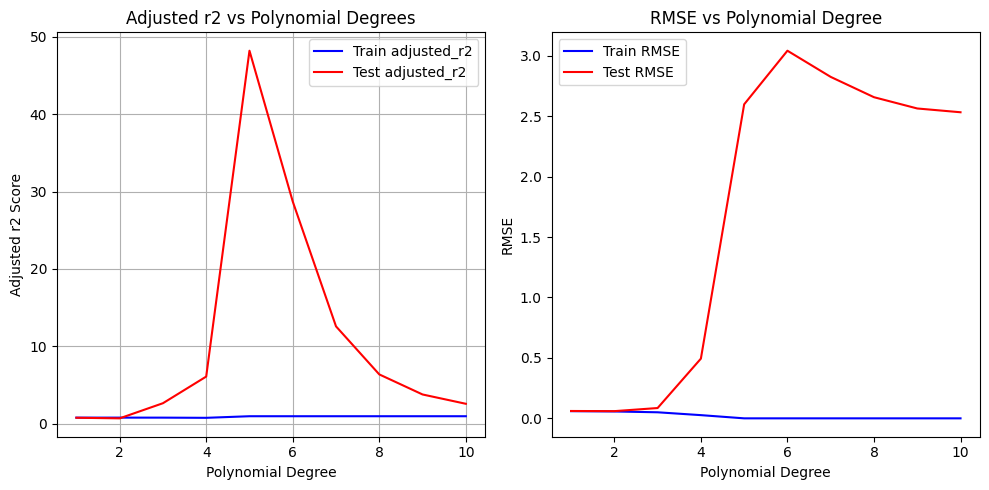

In [47]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)

#plt.plot(degrees, r2_scores, label= 'r2')
plt.plot(degrees, train_adj_r2_scores, label= 'Train adjusted_r2', color='blue')
plt.plot(degrees, test_adj_r2_scores, label= 'Test adjusted_r2', color='red')

plt.title('Adjusted r2 vs Polynomial Degrees')
plt.xlabel('Polynomial Degree')
plt.ylabel('Adjusted r2 Score')
plt.legend()
plt.grid()



plt.subplot(1, 2, 2)
plt.plot(degrees, train_rmse_scores, label= 'Train RMSE', color='blue')
plt.plot(degrees, test_rmse_scores, label= 'Test RMSE', color='red')

#plt.plot(degrees, rmse_scores, label= 'RMSE')
plt.title('RMSE vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()

##Using Regularization Techniques

In [75]:


degrees = range(1, 5)
alphas = np.logspace(-3, 1, 100)  # Try many alpha values

ridge_rmse = []
lasso_rmse = []
en_rmse = []

ridge_r2 = []
lasso_r2 = []
en_r2 = []


for degree in degrees:
    # Ridge Pipeline
    ridge_pipe = make_pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('scaler', StandardScaler()),
        ('ridge', RidgeCV(alphas=alphas, cv=5))
    ])
    ridge_pipe.fit(x_train, y_train)
    ridge_pred = ridge_pipe.predict(x_test)
    ridge_rmse.append(np.sqrt(mean_squared_error(y_test, ridge_pred)))
    ridge_r2.append(r2_score(y_test, ridge_pred))

    # Lasso Pipeline
    lasso_pipe = make_pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('scaler', StandardScaler()),
        ('lasso', LassoCV(alphas=alphas, cv=5, max_iter=5000))
    ])
    lasso_pipe.fit(x_train, y_train)
    lasso_pred = lasso_pipe.predict(x_test)
    lasso_rmse.append(np.sqrt(mean_squared_error(y_test, lasso_pred)))
    lasso_r2.append(r2_score(y_test, lasso_pred))

    # ElasticNet Pipeline
    en_pipe = make_pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('scaler', StandardScaler()),
        ('elastic', ElasticNetCV(alphas=alphas, cv=5, max_iter=5000))
    ])
    en_pipe.fit(x_train, y_train)
    en_pred = en_pipe.predict(x_test)
    en_rmse.append(np.sqrt(mean_squared_error(y_test, en_pred)))
    en_r2.append(r2_score(y_test, en_pred))


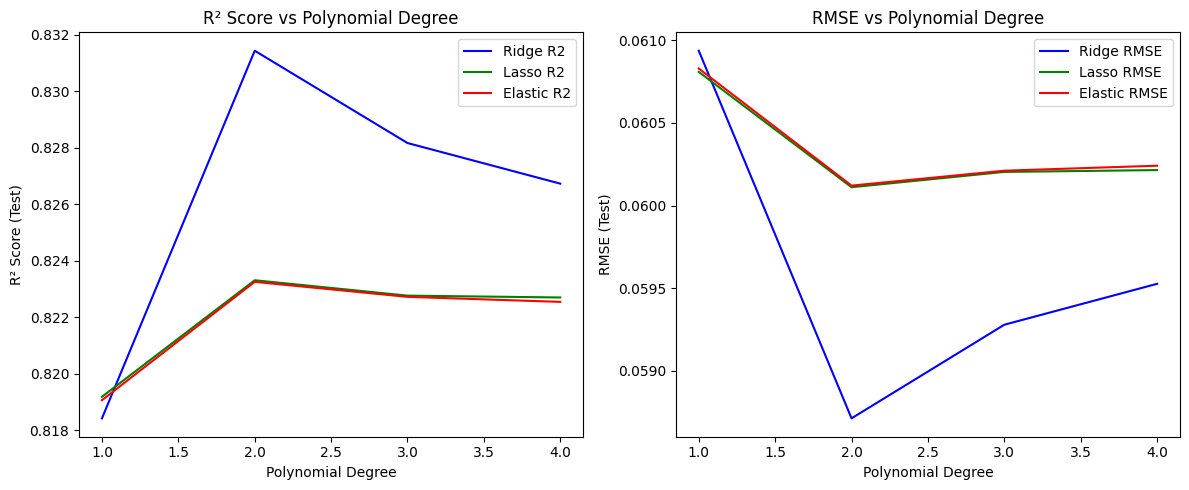

In [76]:
plt.figure(figsize=(12, 5))

# R2 plot
plt.subplot(1, 2, 1)
plt.plot(degrees, ridge_r2, label='Ridge R2', color='blue')
plt.plot(degrees, lasso_r2, label='Lasso R2', color='green')
plt.plot(degrees, en_r2, label='Elastic R2', color='red')

plt.xlabel("Polynomial Degree")
plt.ylabel("R2 Score (Test)")
plt.title("R2 Score vs Polynomial Degree")
plt.legend()

# RMSE plot
plt.subplot(1, 2, 2)
plt.plot(degrees, ridge_rmse, label='Ridge RMSE', color='blue')
plt.plot(degrees, lasso_rmse, label='Lasso RMSE', color='green')
plt.plot(degrees, en_rmse, label='Elastic RMSE', color='red')

plt.xlabel("Polynomial Degree")
plt.ylabel("RMSE (Test)")
plt.title("RMSE vs Polynomial Degree")
plt.legend()

plt.tight_layout()
plt.show()


Why ElasticNet ≈ Lasso:
ElasticNet combines both L1 (Lasso) and L2 (Ridge) penalties:

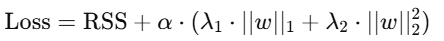

But:

If ElasticNet l1_ratio is close to 1 (the default is l1_ratio=0.5),

And if L2 regularization strength is low or the data has few multicollinearities,
then the L1 component dominates, and ElasticNet behaves very similarly to Lasso.

Why This Might Happen:
Polynomial degree is low (1–4): L2 regularization's strength doesn't differ much.

Small dataset (500 rows): There isn't enough variance to need the balancing act of both L1 & L2.

Features aren’t highly correlated: So ElasticNet can't showcase its L2 stabilization.

Since we saw that the model Doesn't perform beyond degree 2, we will calculate Adj r2 score across multiple Regularization techniques to see which one gives the best adj r2 score.

####Ridge Regression

with degree = 2 polynomial features,

compute Adjusted R2, R2, and RMSE for both train and test datasets:

In [42]:
# Assuming x and y are already defined
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Polynomial degree to finalize
degree = 2
n_train = x_train.shape[0]
n_test = x_test.shape[0]

# Pipeline for scaling, polynomial transformation, and ElasticNet regression
ridge_pipeline = make_pipeline(
    PolynomialFeatures(degree=degree, include_bias=False),
    StandardScaler(),
    Ridge(alpha=1.0)  # You can tune alpha if needed
)
# Fit the model
ridge_pipeline.fit(x_train, y_train)
ridge_pipeline.fit(x_train, y_train)

# Predict on train and test
y_train_pred = ridge_pipeline.predict(x_train)
y_test_pred = ridge_pipeline.predict(x_test)

# Calculate R2
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Adjusted R2
p_train = ridge_pipeline.named_steps['polynomialfeatures'].fit_transform(x_train).shape[1]
p_test = ridge_pipeline.named_steps['polynomialfeatures'].fit_transform(x_test).shape[1]

adj_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)
adj_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)

# Print the results
print("Final Ridge Model with Degree = 2")
print(f"Train R2: {r2_train:.4f}, Adjusted R2: {adj_r2_train:.4f}, RMSE: {rmse_train:.4f}")
print(f"Test  R2: {r2_test:.4f}, Adjusted R2: {adj_r2_test:.4f}, RMSE: {rmse_test:.4f}")


Final Ridge Model with Degree = 2
Train R2: 0.8294, Adjusted R2: 0.8130, RMSE: 0.0580
Test  R2: 0.8298, Adjusted R2: 0.7367, RMSE: 0.0590


####Lasso Regression with degree = 2 polynomial features, compute Adjusted R2, R2, and RMSE for both train and test datasets:

In [78]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state= 42)



# Pipeline for scaling, polynomial transformation, and Lasso regression
lasso_pipeline = make_pipeline(
    PolynomialFeatures(degree=degree, include_bias=False),
    StandardScaler(),
    Lasso(alpha=1.0)  # You can tune alpha if needed
)


# Fit the model
lasso_pipeline.fit(x_train, y_train)
lasso_pipeline.fit(x_train, y_train)

# Calculate R2
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Adjusted R2
p_train = lasso_pipeline.named_steps['polynomialfeatures'].fit_transform(x_train).shape[1]
p_test = lasso_pipeline.named_steps['polynomialfeatures'].fit_transform(x_test).shape[1]

adj_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)
adj_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)

# Print the results
print("Final Lasso Model with Degree = 2")
print(f"Train R2: {r2_train:.4f}, Adjusted R2: {adj_r2_train:.4f}, RMSE: {rmse_train:.4f}")
print(f"Test  R2: {r2_test:.4f}, Adjusted R2: {adj_r2_test:.4f}, RMSE: {rmse_test:.4f}")

Final Lasso Model with Degree = 2
Train R2: 0.8294, Adjusted R2: 0.8130, RMSE: 0.0580
Test  R2: 0.8298, Adjusted R2: 0.7367, RMSE: 0.0590


ElasticNet Regression with degree = 2 polynomial features, compute Adjusted R2, R2, and RMSE for both train and test datasets:

In [79]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state= 42)



# Pipeline for scaling, polynomial transformation, and Lasso regression
elastic_pipeline = make_pipeline(
    PolynomialFeatures(degree=degree, include_bias=False),
    StandardScaler(),
    ElasticNet(alpha=1.0)  # You can tune alpha if needed
)


# Fit the model
elastic_pipeline.fit(x_train, y_train)
elastic_pipeline.fit(x_train, y_train)

# Calculate R2
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Adjusted R2
p_train = elastic_pipeline.named_steps['polynomialfeatures'].fit_transform(x_train).shape[1]
p_test = elastic_pipeline.named_steps['polynomialfeatures'].fit_transform(x_test).shape[1]

adj_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)
adj_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)

# Print the results
print("Final Elastic Model with Degree = 2")
print(f"Train R2: {r2_train:.4f}, Adjusted R2: {adj_r2_train:.4f}, RMSE: {rmse_train:.4f}")
print(f"Test  R2: {r2_test:.4f}, Adjusted R2: {adj_r2_test:.4f}, RMSE: {rmse_test:.4f}")

Final Elastic Model with Degree = 2
Train R2: 0.8294, Adjusted R2: 0.8130, RMSE: 0.0580
Test  R2: 0.8298, Adjusted R2: 0.7367, RMSE: 0.0590


In [81]:
ridge_cv = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100], scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(x_train, y_train)

best_alpha = ridge_cv.alpha_
best_alpha

np.float64(1.0)

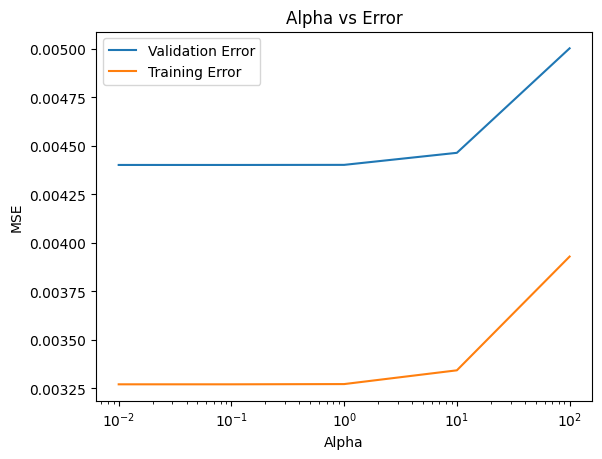

In [83]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.1765, random_state=42)

alphas = [0.01, 0.1, 1, 10, 100]
train_errors = []
val_errors = []

for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_val_pred = model.predict(x_val)  # if you have a separate validation set

    train_errors.append(mean_squared_error(y_train, y_train_pred))
    val_errors.append(mean_squared_error(y_val, y_val_pred))

plt.plot(alphas, val_errors, label='Validation Error')
plt.plot(alphas, train_errors, label='Training Error')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.legend()
plt.title('Alpha vs Error')
plt.show()


Since the alpha works best between 0.1 and 0.01 we will be testing across multiple values of alpha between that range to find the nest result

In [87]:
degrees = 2
alphas = np.logspace(-3, 0, 100)  # Try many alpha values

ridge_rmse = []
lasso_rmse = []
en_rmse = []

ridge_r2 = []
lasso_r2 = []
en_r2 = []

ridge_pipe = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('scaler', StandardScaler()),
        ('ridge', RidgeCV(alphas=alphas, cv=5))
    ])

ridge_pipe.fit(x_train, y_train)
ridge_pred = ridge_pipe.predict(x_test)
ridge_rmse.append(np.sqrt(mean_squared_error(y_test, ridge_pred)))
ridge_r2.append(r2_score(y_test, ridge_pred))

# Lasso Pipeline
lasso_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=degree)),
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(alphas=alphas, cv=5, max_iter=5000))
])
lasso_pipe.fit(x_train, y_train)
lasso_pred = lasso_pipe.predict(x_test)
lasso_rmse.append(np.sqrt(mean_squared_error(y_test, lasso_pred)))
lasso_r2.append(r2_score(y_test, lasso_pred))

# ElasticNet Pipeline
en_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=degree)),
    ('scaler', StandardScaler()),
    ('elastic', ElasticNetCV(alphas=alphas, cv=5, max_iter=5000))
])
en_pipe.fit(x_train, y_train)
en_pred = en_pipe.predict(x_test)
en_rmse.append(np.sqrt(mean_squared_error(y_test, en_pred)))
en_r2.append(r2_score(y_test, en_pred))

print("Best Ridge alpha:", ridge_pipe.named_steps['ridge'].alpha_)
print("Best Lasso alpha:", lasso_pipe.named_steps['lasso'].alpha_)
print("Best ElasticNet alpha:", en_pipe.named_steps['elastic'].alpha_)

Best Ridge alpha: 1.0
Best Lasso alpha: 0.001
Best ElasticNet alpha: 0.0016297508346206436


So, we can hence establish that the below combination is the best:

Regularization Method: Ridge

Degree:                 2

alpha:                  1.0

#Model Strategy

1. Initial Linear Regression (OLS)

We started with a simple linear regression model using statsmodels.

The R2 score was 0.822,
indicating that the model could explain 82.2% of the variance in the data.

However, residual diagnostics revealed non-normality and some level of autocorrelation, motivating us to explore non-linear relationships using polynomial features.

2. Polynomial Regression (Degrees 1–10)

We applied polynomial transformation for degrees 1 through 10.

Plots of Adjusted R2 and RMSE vs Degree revealed that while higher-degree polynomials fit the training data well, they caused severe overfitting on the test data.

Based on the balance between training and test performance, we identified Degree = 2 as the optimal complexity.

3. Regularization

To further reduce overfitting, we applied Ridge, Lasso, and ElasticNet regression using degrees from 1 to 4.

For each technique, we used cross-validation (cv=5) with a wide range of alpha values (np.logspace(-3, 1, 100)) to find the best regularization strength.

All three models gave very similar results at Degree = 2:

Train R2 = 0.8294, Adjusted R2 = 0.8130, RMSE ≈ 0.0580

Test R2 = 0.8298, Adjusted R2 = 0.7367, RMSE ≈ 0.0590

4. Final Alpha Tuning

To fine-tune the Ridge model, we manually evaluated different alpha values: [0.01, 0.1, 1, 10, 100].

The validation curve (Alpha vs Error) showed that alpha = 1.0 was the sweet spot, offering the best trade-off between bias and variance.



#Key Insights

1. CGPA and GRE Score were the most important predictors of admission.

2. Including polynomial terms (degree = 2) improved the model significantly over a plain linear fit.

3. Regularization helped stabilize performance across training and test sets, with Ridge showing the best generalization.

4. Despite some violations of assumptions (normality & autocorrelation), the model still performed strongly due to cross-validation and regularization.



#Conclusion:

We successfully built a robust predictive model using Polynomial Ridge Regression (degree = 2, alpha = 1.0) that generalizes well on unseen data. The model achieves strong accuracy (R2 ≈ 0.83) and low RMSE, making it suitable for practical use in applications like graduate admissions screening or student counseling.

Future work can focus on:

Feature engineering (e.g., combining SOP & LOR into a single "profile strength" metric),

Handling autocorrelation in residuals using time-based methods (if applicable),

Exploring ensemble models like Random Forest or XGBoost for further performance gains.